In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import ndes.nde as nde
import distributions.priors as priors
import compression.IMNN.IMNN_delfi as IMNN

In [3]:
### SET UP FOR SIMULATION CODE ###

# n(z)
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Fiducial power spectrum
C = cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, N)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = cosmic_shear.power_spectrum(theta_plus, pz_fid, modes, np.zeros((nz, nz)))
    Cm = cosmic_shear.power_spectrum(theta_minus, pz_fid, modes, np.zeros((nz, nz)))
    C0 = cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, np.zeros((nz, nz)))

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = cosmic_shear.fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

In [4]:
# Define the simulator function: takes parameters, spits out simulated data
# Should have the form: simulator(parameters, args) -> simulated dataset
simulator = cosmic_shear.simulate
simulator_args = [pz_fid, modes, N, nl]

In [5]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

In [6]:
## Define the compression function: takes data, spits out compressed summaries
## Should have the form compressor(data, args) -> compressed summaries
## NB: compression should be set-up like a quasi maximum-likelihood estimator
der = np.array([0.05, 0.05, 0.05, 0.05, 0.05]) * theta_fiducial
initial_sims = 1000
n_epochs = 100
n = IMNN.get_network(simulator, simulator_args, theta_fiducial, der, initial_sims, "cosmic_shear", make_simulations = True)

Derivative simulations: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


(1000, 550) (100, 5, 550) (100, 5, 550) (1000, 550) (100, 5, 550) (100, 5, 550)
[550, 275, 137, 68, 34, 17, 8]
saving model as compression/cosmic_shear.meta
saving the graph as compression/cosmic_shear.meta


In [7]:
IMNN.train_IMNN(n, n_epochs)

100%|██████████| 100/100 [00:06<00:00, 25.40it/s, detF=3.39e+22, lndetF_test=8.12e+22]


saving the graph as compression/cosmic_shear.meta


In [8]:
compressor = IMNN.IMNN_compressor
compressor_args = n

In [9]:
print("Target det(F) = ", np.linalg.det(F))
print("IMNN det(F) = ", n.history["det(test F)"][-1])

Target det(F) =  4.277631554866884e+22
IMNN det(F) =  8.120999e+22


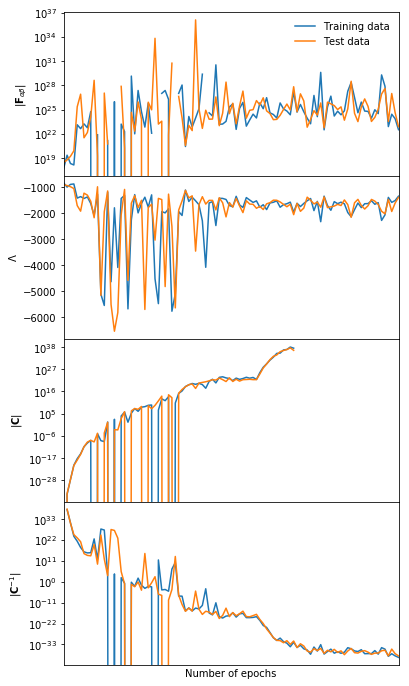

In [10]:
fig, ax = plt.subplots(4, 1, sharex = True, figsize = (6, 12))
plt.subplots_adjust(hspace = 0)
end = len(n.history["det(test F)"])
epochs = np.arange(1, end + 1)
a, = ax[0].plot(epochs, n.history["det(F)"][:end], label = 'Training data')
b, = ax[0].plot(epochs, n.history["det(test F)"][:end], label = 'Test data')
ax[0].set_yscale('log')
ax[0].legend(frameon = False)
ax[0].set_ylabel(r'$|{\bf F}_{\alpha\beta}|$')
ax[0].set_xticks([])
ax[1].plot(epochs, n.history["Λ"][:end])
ax[1].plot(epochs, n.history["test Λ"][:end])
ax[1].set_xlabel('Number of epochs')
ax[1].set_ylabel(r'$\Lambda$')
ax[1].set_xlim([1, len(epochs)]);
ax[2].plot(epochs, n.history["det(C)"])
ax[2].plot(epochs, n.history["det(test C)"])
ax[2].set_yscale('log')
ax[2].set_xlabel('Number of epochs')
ax[2].set_ylabel(r'$|{\bf C}|$')
ax[2].set_xlim([1, len(epochs)]);
ax[3].plot(epochs, n.history["det(iC)"])
ax[3].plot(epochs, n.history["det(test iC)"])
ax[3].set_xlabel('Number of epochs')
ax[3].set_ylabel(r'$|{\bf C}^{-1}|$')
ax[3].set_yscale('log')
ax[3].set_xlim([1, len(epochs)]);

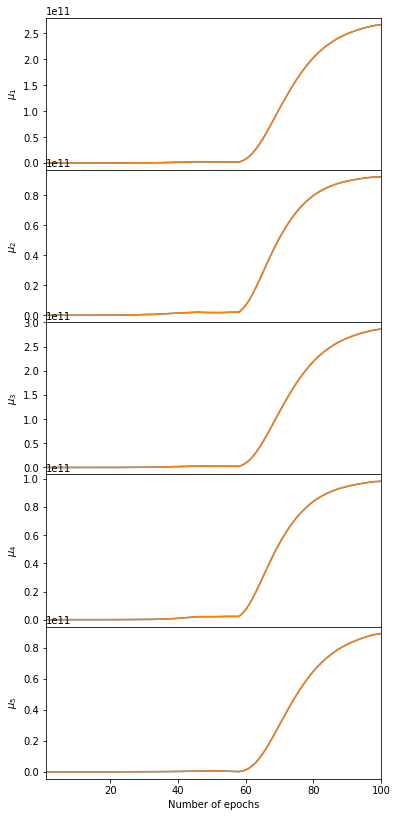

In [11]:
fig, ax = plt.subplots(5, 1, figsize = (6, 14))
plt.subplots_adjust(hspace = 0)
for i in range(5):
    ax[i].plot(epochs, np.array(n.history['μ'])[:, i])
    ax[i].plot(epochs, np.array(n.history['test μ'])[:, i])
    ax[i].set_ylabel("$\mu_{" + str(i + 1) + "}$")
    ax[i].set_xlim([1, len(epochs)])
    if i < 4:
        ax[i].set_xticks([])
    else:
        ax[i].set_xlabel('Number of epochs')

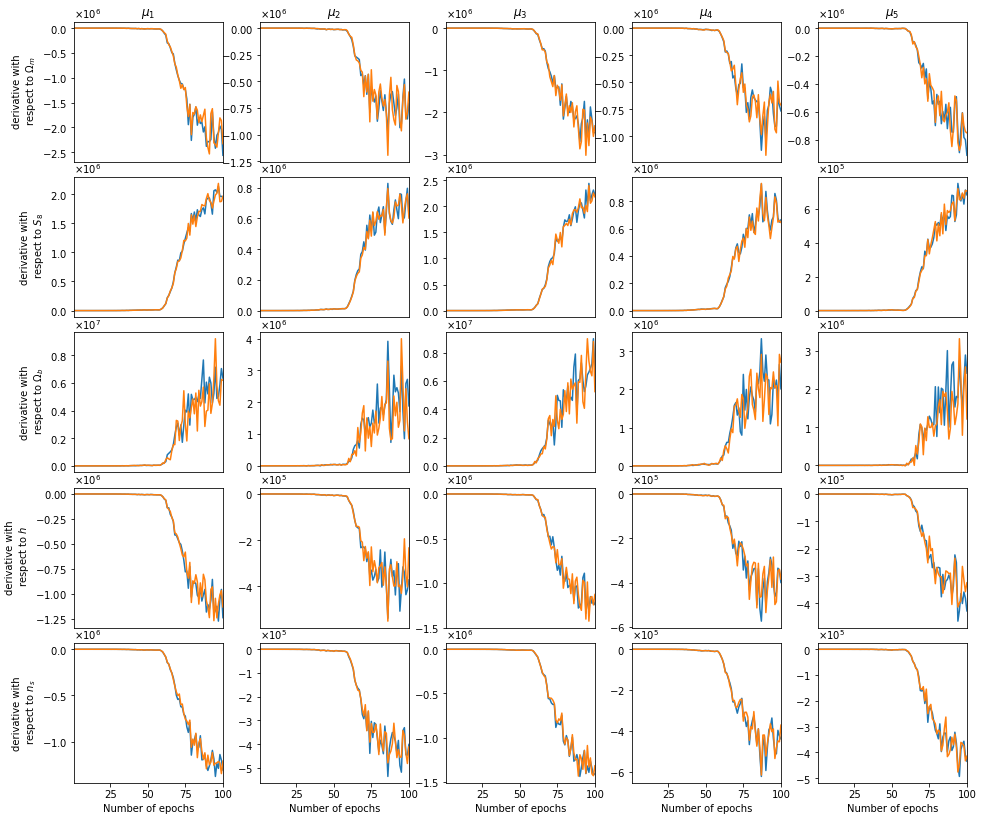

In [12]:
fig, ax = plt.subplots(5, 5, figsize = (16, 14))
plt.subplots_adjust(hspace = 0.11, wspace = 0.25)
plot_labels = ["$\Omega_m$", "$S_8$", "$\Omega_b$", "$h$", "$n_s$"]
for i in range(5):
    for j in range(5):
        ax[i, j].plot(epochs, np.array(n.history['dμdθ'])[:, i, j])
        ax[i, j].plot(epochs, np.array(n.history['test dμdθ'])[:, i, j])
        ax[i, j].set_xlim([1, len(epochs)]);
        ax[i, j].ticklabel_format(axis = "y", style = 'sci', scilimits = (0, 0), useMathText = True)
        if i == 0:
            ax[i, j].set_title("$\mu_{" + str(j + 1) + "}$")
        if i == 4:
            ax[i, j].set_xlabel('Number of epochs')
        if i < 4:
            ax[i, j].set_xticks([])
        if j == 0:
            ax[i, j].set_ylabel("derivative with\n respect to " + plot_labels[i])

In [13]:
import pickle
with open("simulations/cosmic_shear.pickle", "rb") as file:
    data = pickle.load(file)

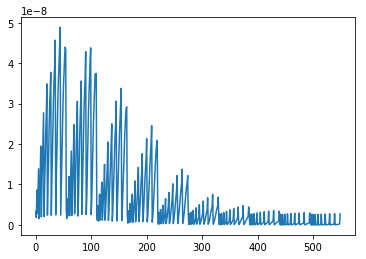

In [14]:
plt.plot(data["x_central"][0])

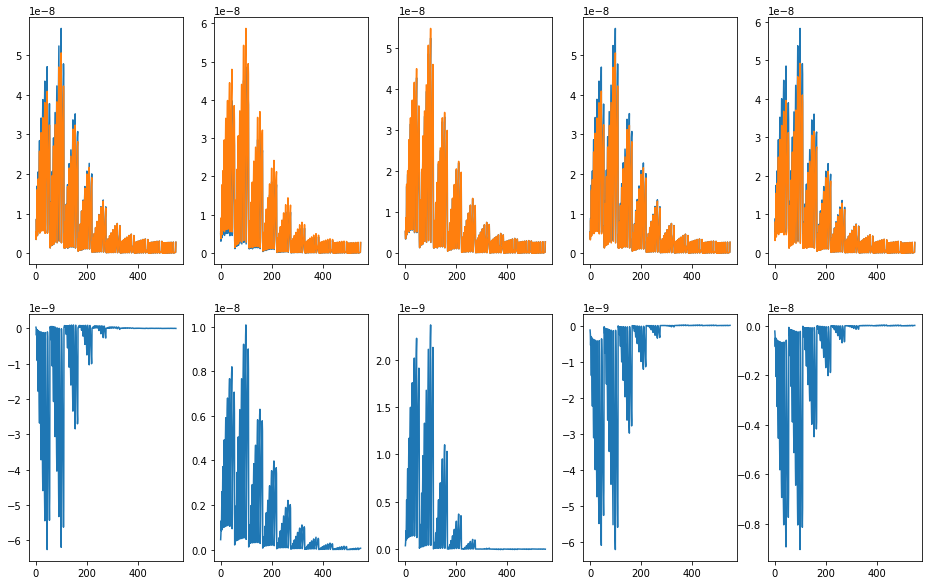

In [15]:
fig, ax = plt.subplots(2, 5, figsize = (16, 10))

for j in range(len(data["x_m"][0])):
    ax[0, j].plot(data["x_m"][1, j])
    ax[0, j].plot(data["x_p"][1, j])
    ax[1, j].plot(data["x_p"][1, j] - data["x_m"][1, j])

In [16]:
# Data vector
# Simulate some cosmic shear data
data = simulator(theta_fiducial, simulator_args)
compressed_data = compressor(data, compressor_args)
print("Fiducial parameter values = ", theta_fiducial)
print("IMNN MLE values = ", compressed_data)

Fiducial parameter values =  [0.3  0.8  0.05 0.7  0.96]
IMNN MLE values =  [0.3006284  0.7979639  0.05298552 0.6960352  0.9645259 ]


In [17]:
# Create the DELFI MDN object
n_components = 3
mdn = nde.DelfiMixtureDensityNetwork(compressed_data, prior, [lower, upper], np.linalg.inv(n.sess.run(n.test_F)), theta_fiducial, n_components, n_hidden = [50, 50], activations = [tf.nn.tanh, tf.nn.tanh], names = names, labels = labels, ranges = ranges)

Pretraining data:   0%|          | 176/50000 [00:00<00:28, 1754.00it/s]

Generating pre-training data...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training on the pre-training data...


Epochs: 100%|██████████| 100/100 [05:55<00:00,  3.47s/it, loss=7.9, val_loss=7.77]


Done.
Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving fish_pretrain_post.pdf


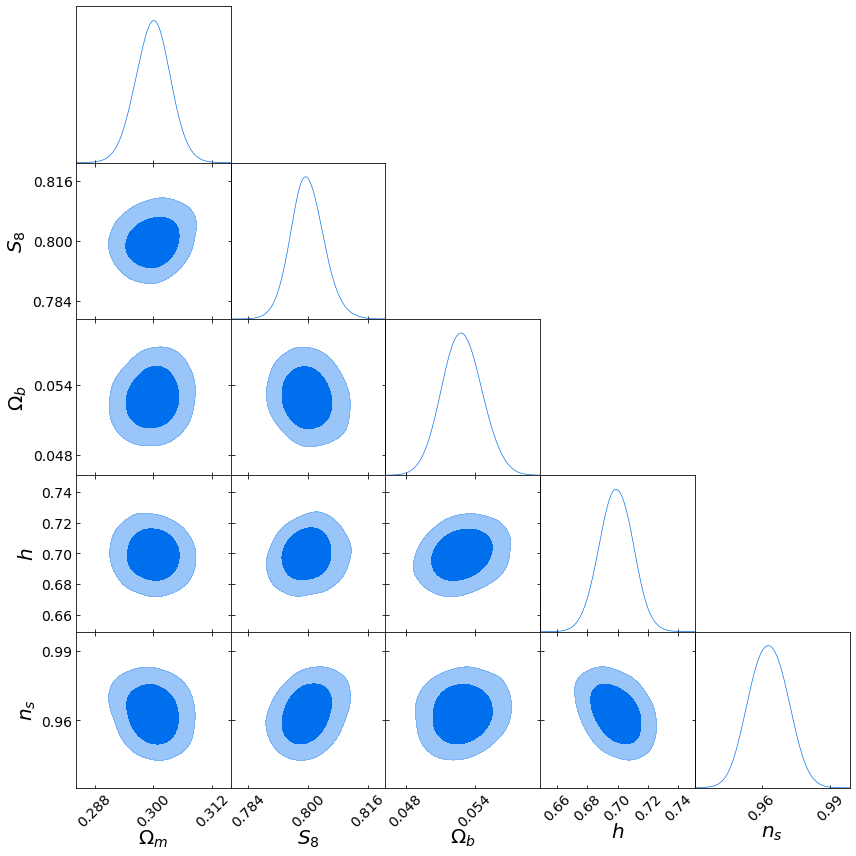

In [18]:
# Do the Fisher pre-training
mdn.sess.run(tf.global_variables_initializer())
mdn.fisher_pretraining(50000, prior, epochs=100, epsilon = 1e-37)

  0%|          | 0/500 [00:00<?, ?it/s]

Running initial 500 sims...


Epochs:   3%|▎         | 3/100 [00:00<00:04, 21.61it/s, loss=12.2]             

Done.


Epochs: 100%|██████████| 100/100 [00:04<00:00, 22.75it/s, loss=0.952, val_loss=1.38]


Sampling approximate posterior...


/hdd/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/hdd/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)


Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving seq_train_post_0.pdf


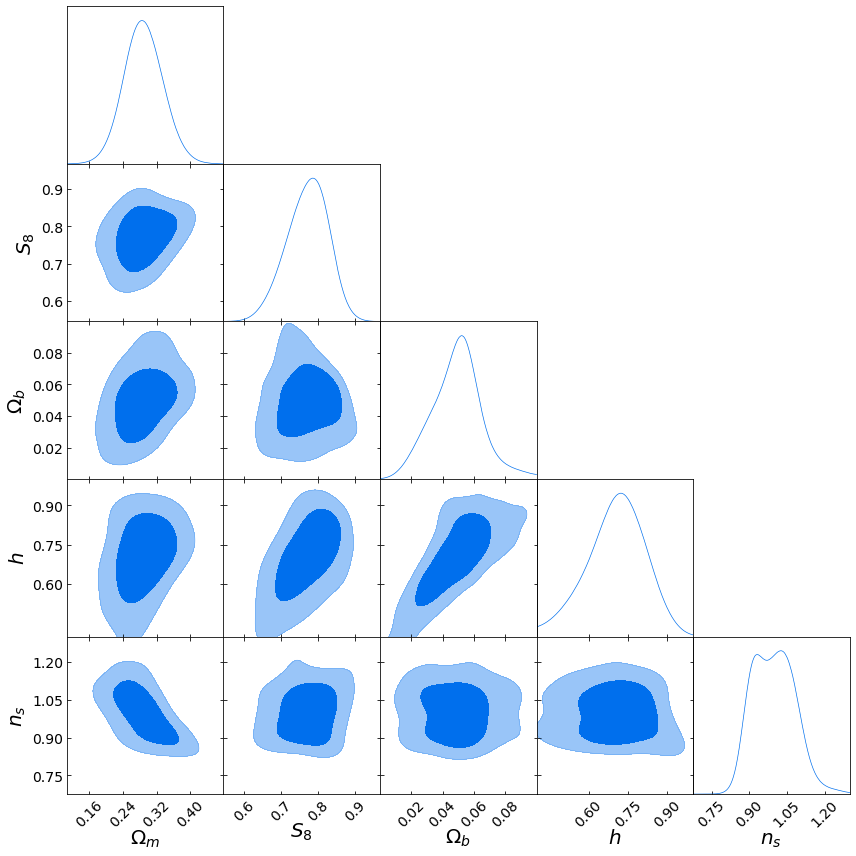

Population 1/15
Sampling proposal density...


/hdd/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/hdd/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


Epochs:   2%|▏         | 2/100 [00:00<00:07, 12.82it/s, loss=10.6]               

Done.


Epochs: 100%|██████████| 100/100 [00:08<00:00, 12.26it/s, loss=1.07, val_loss=2.22]


Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving seq_train_post_1.pdf


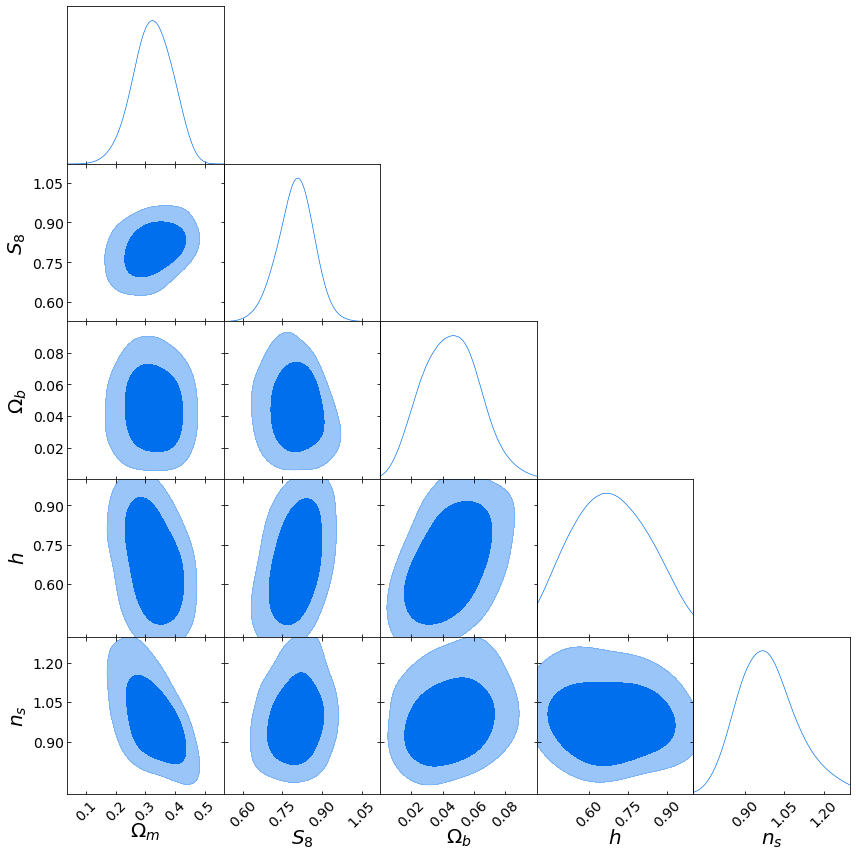

Population 2/15
Sampling proposal density...


/hdd/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/hdd/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


Epochs:   2%|▏         | 2/100 [00:00<00:08, 11.23it/s, loss=3.8]                

Done.


Epochs:  88%|████████▊ | 88/100 [00:07<00:01, 11.95it/s, loss=0.822]               IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epochs:   1%|          | 1/100 [00:00<00:18,  5.45it/s, loss=1.53]               

Done.


Epochs:  97%|█████████▋| 97/100 [00:16<00:00,  6.40it/s, loss=1.91]                IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epochs: 100%|██████████| 100/100 [00:21<00:00,  4.61it/s, loss=1.29, val_loss=2.7]  


Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving seq_train_post_7.pdf


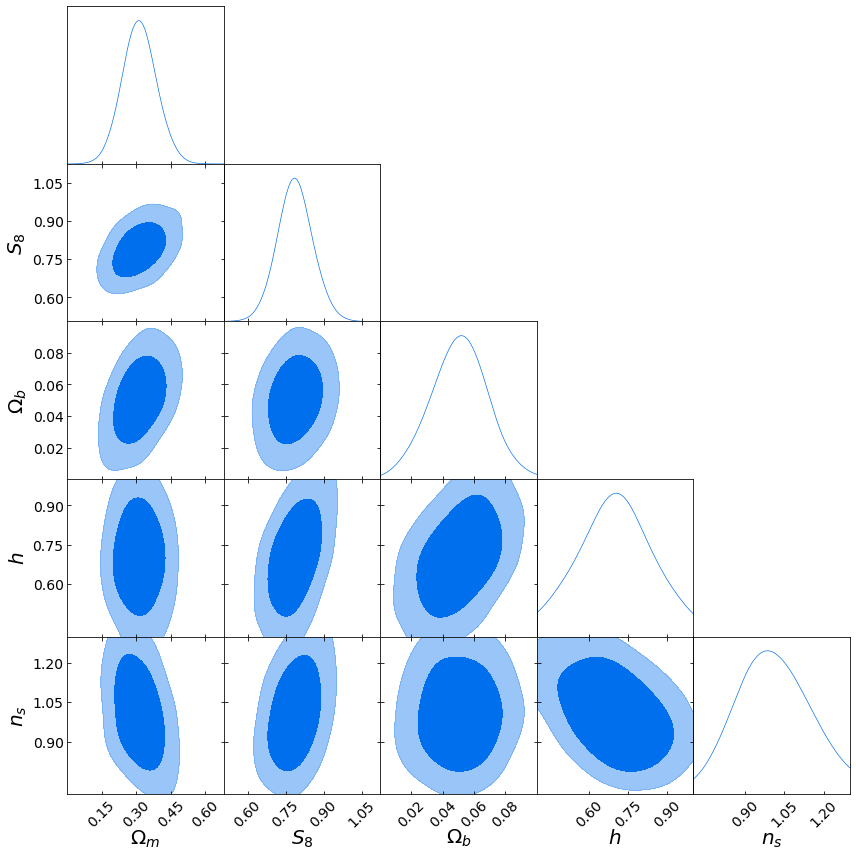

Population 8/15
Sampling proposal density...


/hdd/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/hdd/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 17%|█▋        | 83/500 [00:34<02:53,  2.40it/s]

Simulator returns exception for parameter values: [0.18811713 0.89786251 0.05994417 0.79547573 1.20476551] (rank 0)
Simulator returns exception for parameter values: [0.18811713 0.89786251 0.05994417 0.79547573 1.20476551] (rank 0)
Simulator returns exception for parameter values: [0.16759169 0.91651985 0.05753397 0.77275189 1.22339067] (rank 0)
Simulator returns exception for parameter values: [0.16759169 0.91651985 0.05753397 0.77275189 1.22339067] (rank 0)
Simulator returns exception for parameter values: [0.16759169 0.91651985 0.05753397 0.77275189 1.22339067] (rank 0)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s, loss=1.39] 

Done.


Epochs:  12%|█▏        | 12/100 [00:03<00:24,  3.56it/s, loss=1.44]                IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epochs: 100%|██████████| 100/100 [00:28<00:00,  3.60it/s, loss=0.848, val_loss=5.06] 


Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving seq_train_post_9.pdf


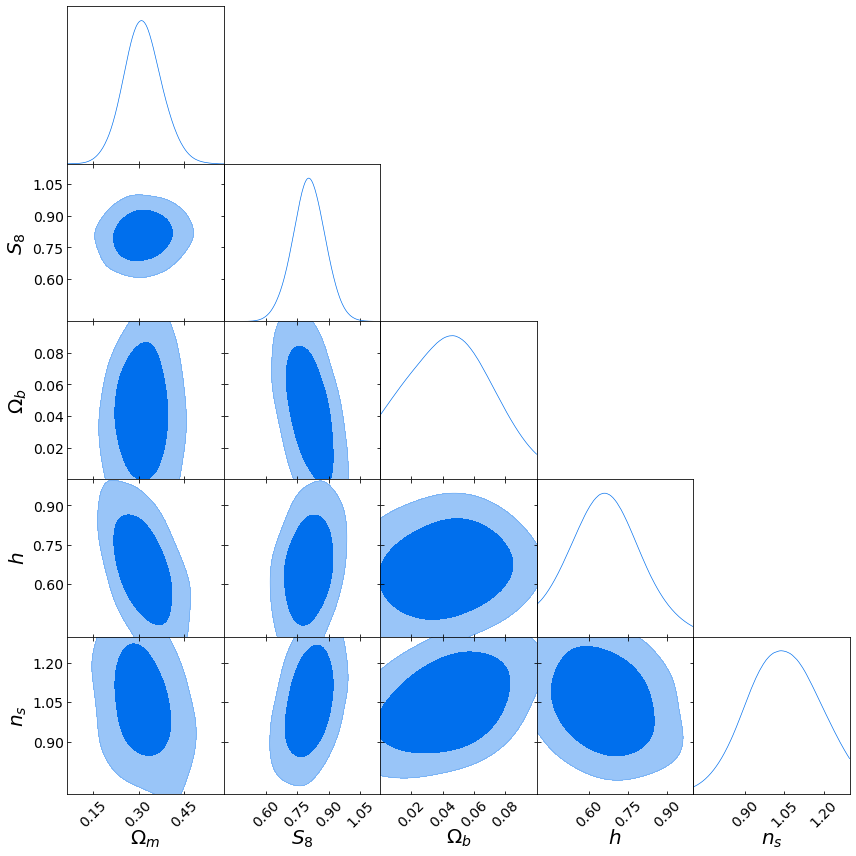

Population 10/15
Sampling proposal density...


/hdd/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/hdd/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 27%|██▋       | 136/500 [00:57<02:24,  2.52it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s, loss=2.11] 

Done.


Epochs: 100%|██████████| 100/100 [00:30<00:00,  2.16it/s, loss=0.652, val_loss=0.735]


Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving seq_train_post_11.pdf


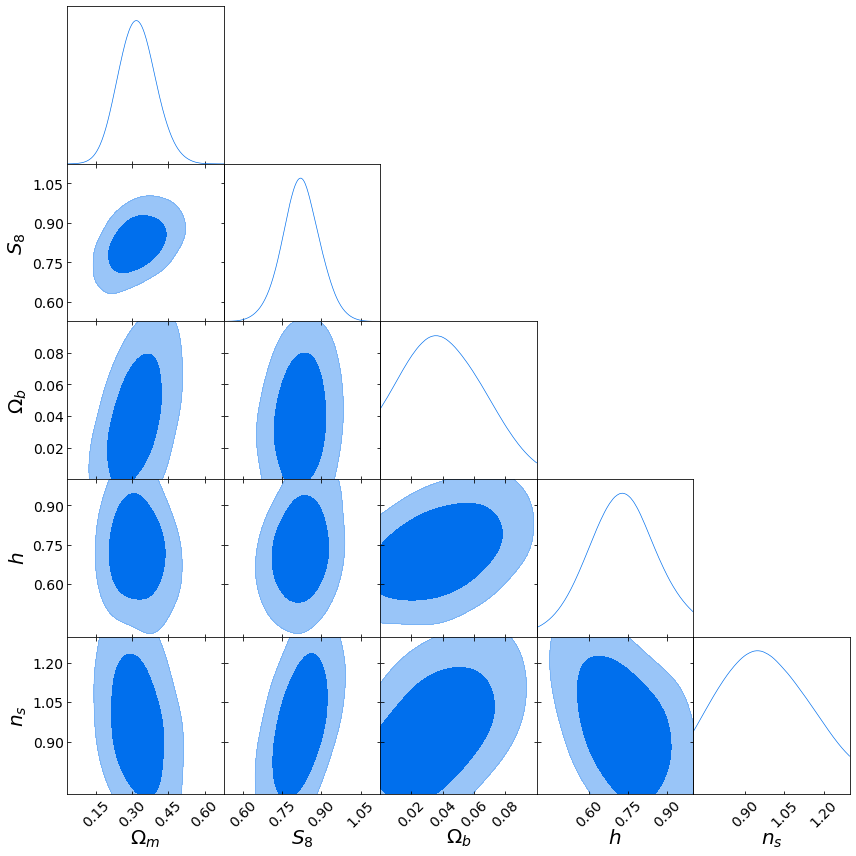

Population 12/15
Sampling proposal density...


/hdd/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/hdd/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 71%|███████   | 354/500 [02:53<01:02,  2.32it/s]

Simulator returns exception for parameter values: [0.10270259 0.75753098 0.02413149 0.70339772 1.00225052] (rank 0)
Simulator returns exception for parameter values: [0.16488209 0.76164638 0.03718276 0.68625083 1.0150932 ] (rank 0)
Simulator returns exception for parameter values: [0.16488209 0.76164638 0.03718276 0.68625083 1.0150932 ] (rank 0)
Simulator returns exception for parameter values: [0.16488209 0.76164638 0.03718276 0.68625083 1.0150932 ] (rank 0)


 72%|███████▏  | 361/500 [02:57<01:05,  2.13it/s]

Simulator returns exception for parameter values: [0.13805312 0.76478543 0.01995751 0.71304174 0.93418997] (rank 0)
Simulator returns exception for parameter values: [0.13805312 0.76478543 0.01995751 0.71304174 0.93418997] (rank 0)
Simulator returns exception for parameter values: [0.14268937 0.77199384 0.02030068 0.71473271 0.95125263] (rank 0)
Simulator returns exception for parameter values: [0.14268937 0.77199384 0.02030068 0.71473271 0.95125263] (rank 0)
Simulator returns exception for parameter values: [0.14268937 0.77199384 0.02030068 0.71473271 0.95125263] (rank 0)
Simulator returns exception for parameter values: [0.10430426 0.75028659 0.01353447 0.67363612 0.95885095] (rank 0)
Simulator returns exception for parameter values: [0.10430426 0.75028659 0.01353447 0.67363612 0.95885095] (rank 0)


 95%|█████████▌| 476/500 [03:50<00:11,  2.11it/s]

Simulator returns exception for parameter values: [0.13922652 0.77892107 0.02294004 0.96310983 0.98907302] (rank 0)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s, loss=0.615]

Done.


Epochs: 100%|██████████| 100/100 [00:48<00:00,  2.11it/s, loss=0.464, val_loss=1.29]


Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving seq_train_post_12.pdf


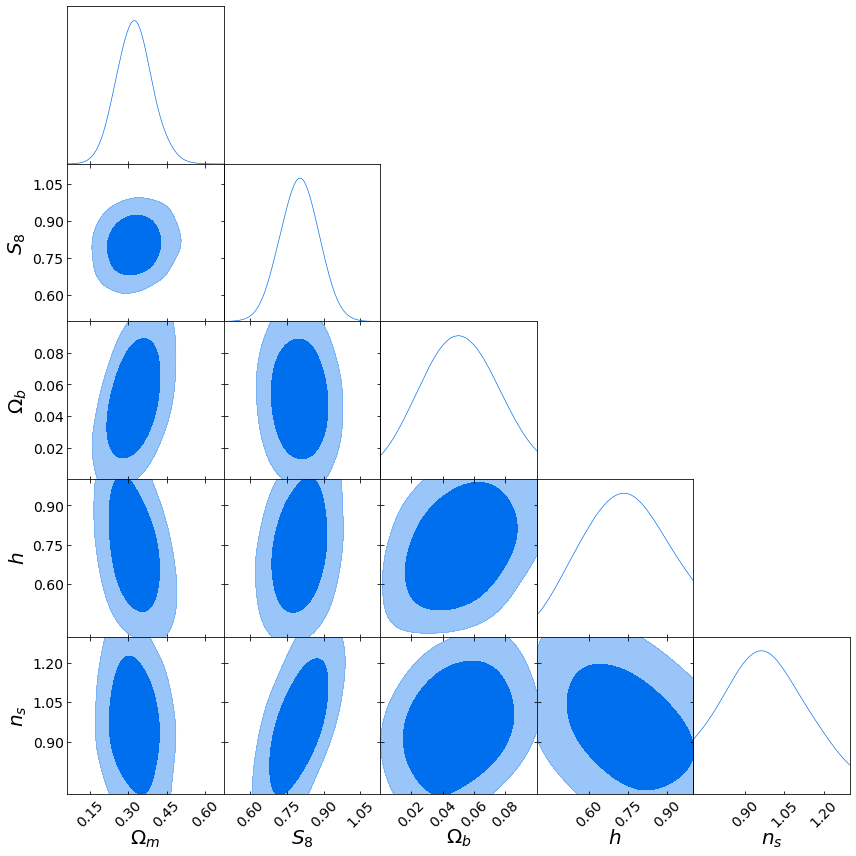

Population 13/15
Sampling proposal density...


/hdd/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/hdd/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s, loss=0.735]

Done.


Epochs: 100%|██████████| 100/100 [00:53<00:00,  1.83it/s, loss=1.52, val_loss=0.822] 


Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving seq_train_post_13.pdf


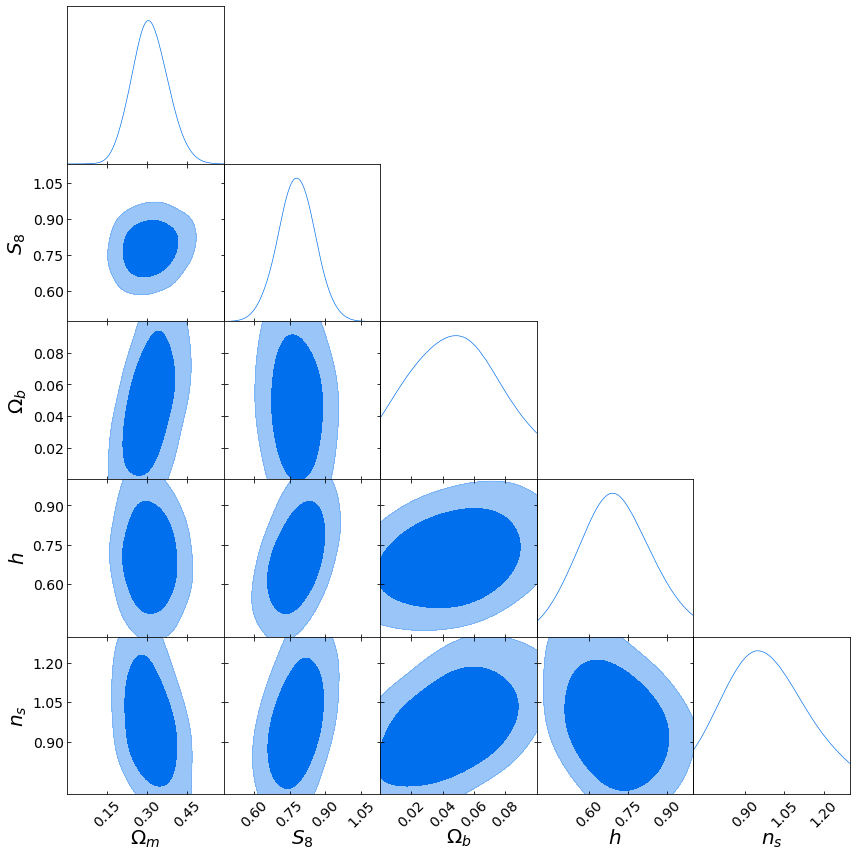

Population 14/15
Sampling proposal density...


/hdd/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/hdd/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s, loss=0.717]  

Done.


Epochs:  36%|███▌      | 36/100 [00:14<00:26,  2.41it/s, loss=1.01]                   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epochs:  42%|████▏     | 42/100 [00:20<00:27,  2.15it/s, loss=1.01]                  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving seq_train_post_15.pdf


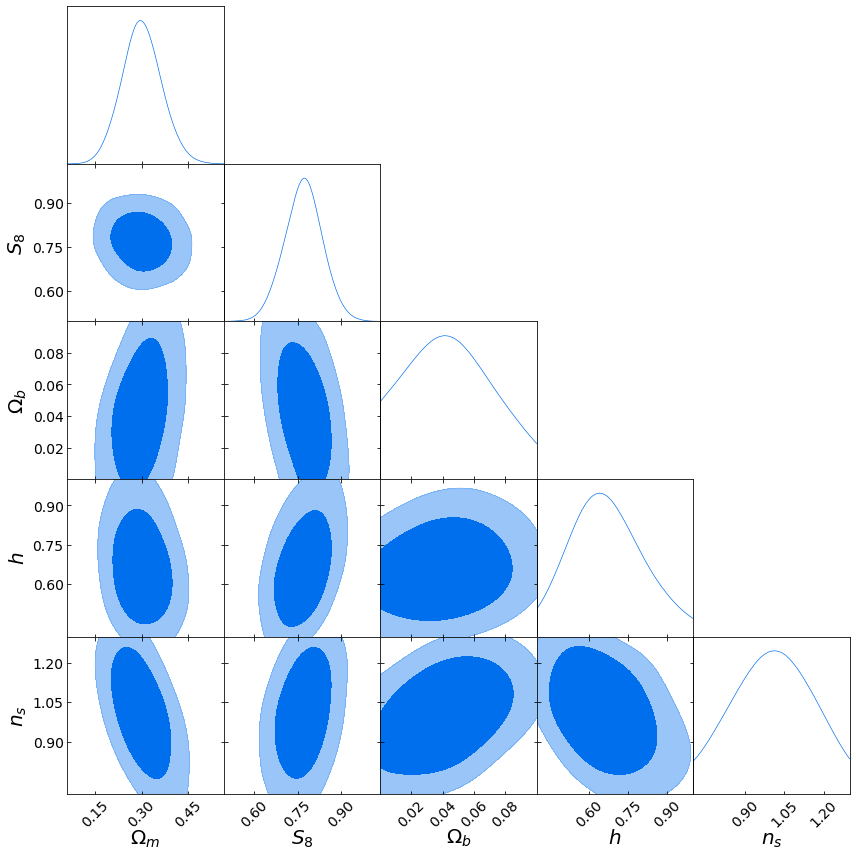

Epochs:   2%|▏         | 6/300 [00:00<00:05, 55.96it/s, loss=0.15, val_loss=0.142]   

Final round of training with larger SGD batch size...


Epochs: 100%|██████████| 300/300 [00:04<00:00, 66.26it/s, loss=-0.412, val_loss=-0.126] 


Done.
Sampling approximate posterior...


/hdd/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/hdd/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)


Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving seq_train_post_final.pdf


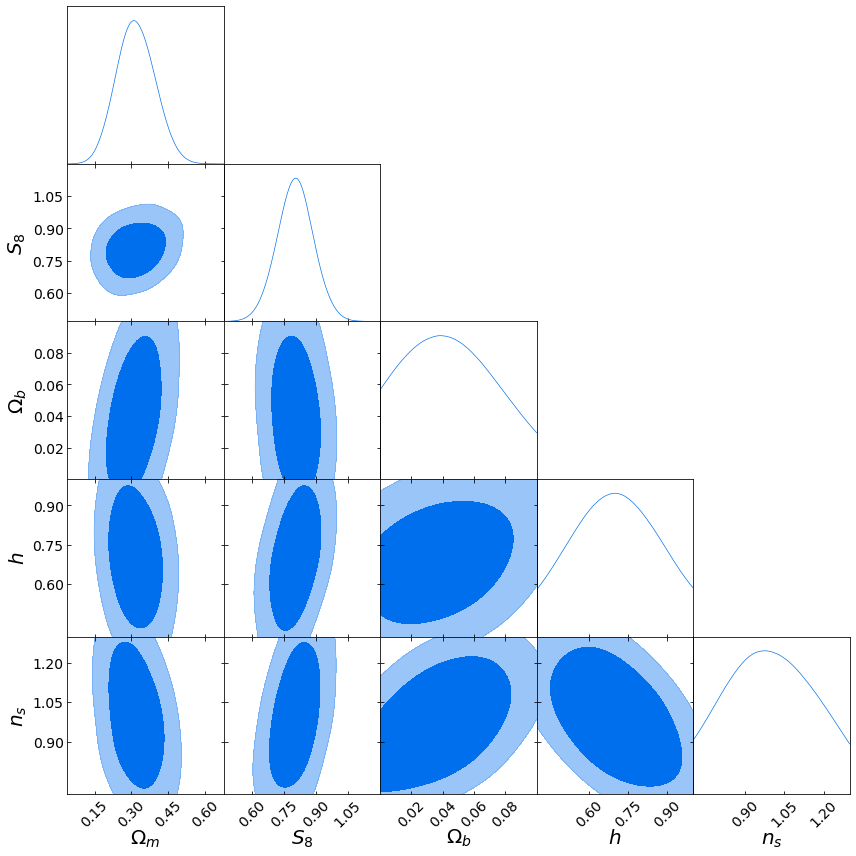

In [19]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*np.linalg.inv(n.sess.run(n.test_F)), lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 15

# Do the SNL training
mdn.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, proposal, epsilon = 1e-37, simulator_args=simulator_args, compressor_args=compressor_args)

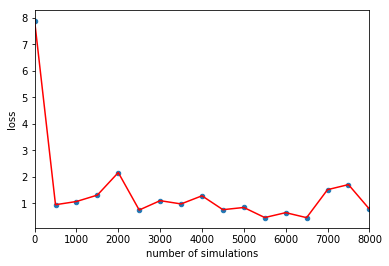

In [20]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()

In [24]:
emcee_samples = np.loadtxt("emcee_samples.dat")
posterior_samples = np.loadtxt("posterior_samples.dat")
IMNN_samples = mdn.posterior_samples

Removed no burn in
Removed no burn in
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


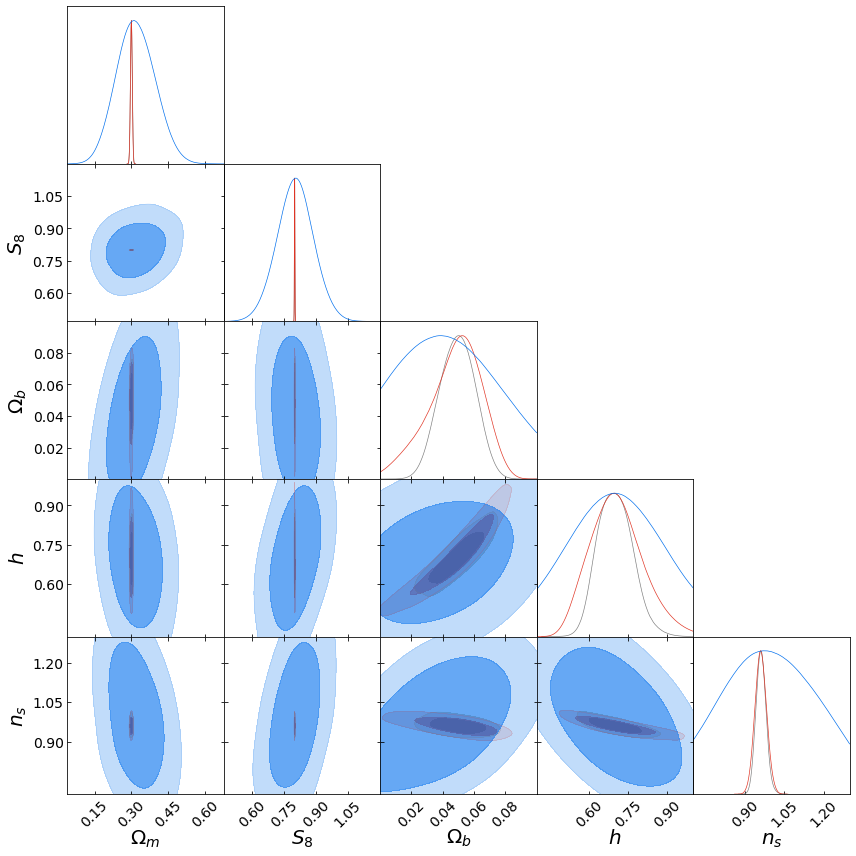

In [25]:
mdn.triangle_plot([emcee_samples, posterior_samples, IMNN_samples])